In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rtree.index import Index as RTreeIndex
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
from tqdm import tqdm
import networkx as nx

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:

def get_geoms(G):
    return ox.utils_graph.graph_to_gdfs(G, nodes=False)['geometry']

def get_rtree(G, geoms):
    # build the r-tree spatial index by position for subsequent iloc
    rtree = RTreeIndex()
    for pos, bounds in enumerate(geoms.bounds.values):
        rtree.insert(pos, bounds)
    return rtree
bk = ox.io.load_graphml('bk.graphml')
bk_geoms = get_geoms(bk)
bk_rtree = get_rtree(bk, bk_geoms)

In [62]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
ROUTE = 'B70'
COLUMNS = ['route', 'x', 'latitude', 'longitude', 'bus_id', 'datetime']
X = 0
Y = 1

In [63]:
bus_df = pd.read_csv(f'{DATA_DIR}/MTA-Bus-2021-7-18.csv', names=COLUMNS)
bus_df = bus_df[(bus_df['route'].str.endswith(ROUTE))]

In [64]:
bus_gdf = gpd.GeoDataFrame(bus_df, geometry=gpd.points_from_xy(bus_df['longitude'], bus_df['latitude'])).set_crs(CRS_PLOT)

In [65]:
b_gdf = bus_gdf[(bus_gdf['route'].str.contains(ROUTE))]
b_gdf.head()

,route,x,latitude,longitude,bus_id,datetime,geometry
587,MTA NYCT_B70,0,40.638351,-74.006554,MTA NYCT_398,Sun Jul 11 10:29:40 EDT 2021,POINT (-74.00655 40.63835)
596,MTA NYCT_B70,1,40.656006,-74.011719,MTA NYCT_395,Sun Jul 11 10:29:42 EDT 2021,POINT (-74.01172 40.65601)
984,MTA NYCT_B70,1,40.614731,-74.023087,MTA NYCT_445,Sun Jul 11 10:30:07 EDT 2021,POINT (-74.02309 40.61473)
995,MTA NYCT_B70,1,40.637310,-74.007637,MTA NYCT_456,Sun Jul 11 10:30:03 EDT 2021,POINT (-74.00764 40.63731)
1007,MTA NYCT_B70,0,40.614452,-74.022865,MTA NYCT_469,Sun Jul 11 10:29:46 EDT 2021,POINT (-74.02287 40.61445)


In [66]:
b_gdf = b_gdf[['bus_id', 'x', 'datetime', 'latitude', 'longitude', 'geometry']]
b_gdf['datetime'] = pd.to_datetime(b_gdf['datetime']).dt.tz_localize(None)

In [67]:
b_gdf = b_gdf.sort_values(by=['bus_id', 'datetime'])

In [68]:
b_gdf

,bus_id,x,datetime,latitude,longitude,geometry
156301,MTA NYCT_239,1,2021-07-11 11:35:45,40.654041,-74.008537,POINT (-74.00854 40.65404)
157105,MTA NYCT_239,1,2021-07-11 11:37:07,40.654755,-74.006966,POINT (-74.00697 40.65475)
159245,MTA NYCT_239,1,2021-07-11 11:38:08,40.654552,-74.006325,POINT (-74.00632 40.65455)
161425,MTA NYCT_239,1,2021-07-11 11:39:09,40.653435,-74.005424,POINT (-74.00542 40.65343)
163880,MTA NYCT_239,1,2021-07-11 11:40:10,40.652355,-74.005730,POINT (-74.00573 40.65236)
...,...,...,...,...,...,...
7028921,MTA NYCT_809,1,2021-07-13 08:36:44,40.620541,-74.024269,POINT (-74.02427 40.62054)
7032723,MTA NYCT_809,1,2021-07-13 08:37:45,40.620224,-74.024620,POINT (-74.02462 40.62022)
7037644,MTA NYCT_809,1,2021-07-13 08:38:46,40.618542,-74.026093,POINT (-74.02609 40.61854)
7041534,MTA NYCT_809,1,2021-07-13 08:39:46,40.618015,-74.026550,POINT (-74.02655 40.61802)


In [69]:
b_gdf.to_csv(f'{EXPORTS_DIR}/trajectories/{ROUTE.lower()}_all_trajectories.csv', index=False)

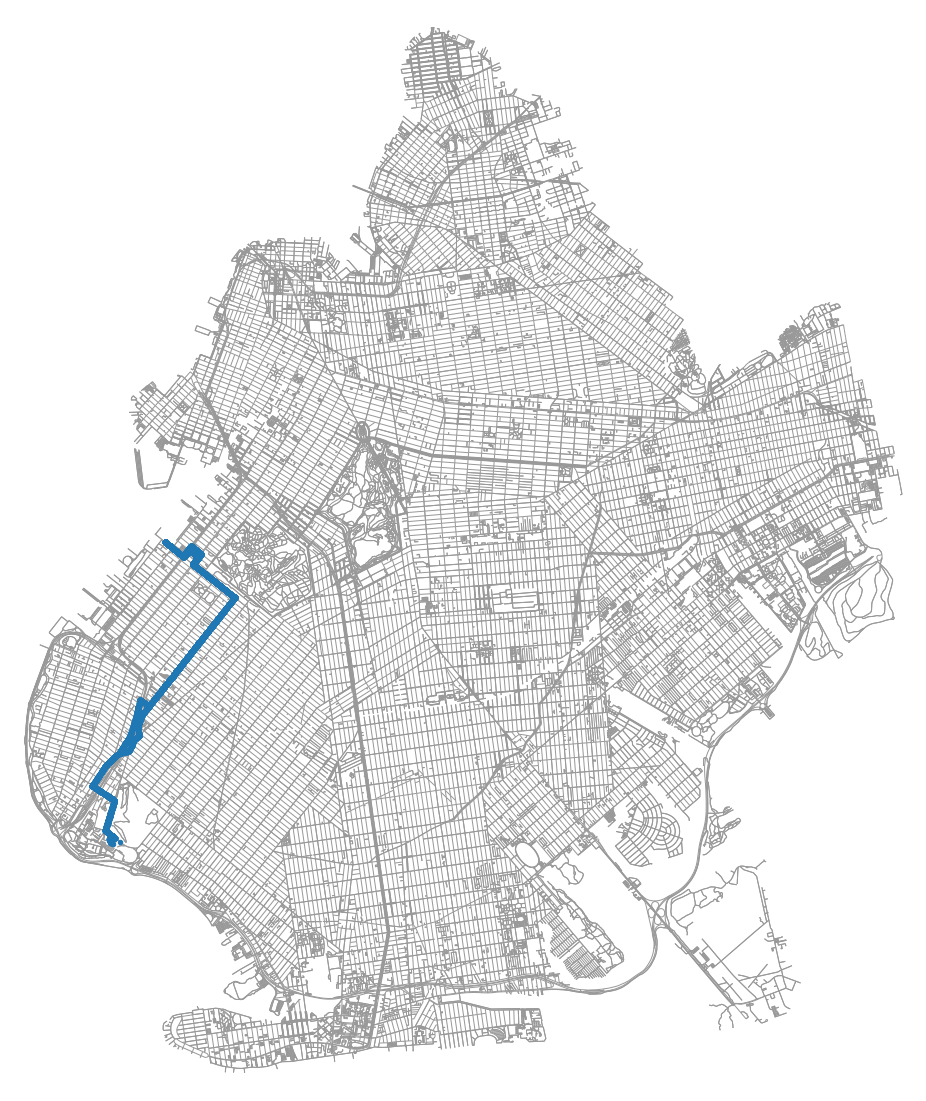

In [70]:
fig, ax = plt.subplots(figsize=(20, 20))
ox.plot_graph(bk, ax=ax, bgcolor=None, node_size=0, show=False, close=False)
b_gdf.plot(ax=ax, zorder=20, markersize=20)
plt.show()

In [71]:
class Trajectory:
    def __init__(self, points):
        self.points = points
        self.df = pd.DataFrame(points, columns=['lon', 'lat', 'time'])

In [72]:
def get_trajectories(b_gdf):
    trajectories = []
    curr_bus_id = None
    curr_x = None
    curr_trajectory = []
    LENGTH_THRESHOLD = 10
    for i in range(0, len(b_gdf)):
        row = b_gdf.iloc[i]
        lat = row['latitude']
        lon = row['longitude']
        time = row['datetime']

        if curr_x == None and curr_bus_id == None:
            curr_x = row['x']
            curr_bus_id = row['bus_id']
            if curr_x == X:
                curr_trajectory.append((lon, lat, time))
        elif row['bus_id'] == curr_bus_id:
            if row['x'] == curr_x:
                if row['x'] == X:
                    curr_trajectory.append((lon, lat, time))
            else:
                if row['x'] == Y:
                    if len(curr_trajectory) > LENGTH_THRESHOLD:
                        trajectories.append(Trajectory(curr_trajectory))
                    curr_trajectory = []
                curr_x = row['x']
        else:
            if len(curr_trajectory) > LENGTH_THRESHOLD:
                trajectories.append(Trajectory(curr_trajectory))
            curr_trajectory = []
            curr_bus_id = row['bus_id']
            curr_x = row['x']
            if curr_x == X:
                curr_trajectory.append((lon, lat, time))
    if len(curr_trajectory) > LENGTH_THRESHOLD:
        trajectories.append(Trajectory(curr_trajectory))
    return trajectories

In [73]:
trajectories = get_trajectories(b_gdf)[0:20]
display(len(trajectories))

20

In [74]:
def k_nearest_edges(rtree, geoms, x, y, k=3):
    # use r-tree to find possible nearest neighbors, one point at a time,
    # then minimize euclidean distance from point to the possible matches
    xy = (x, y)
    dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
    dists_df = pd.DataFrame([a[0][0:2] + (a[1],) for a in zip(dists.index, dists)], columns=['u', 'v', 'dist'])
    return dists_df.nsmallest(k, 'dist', keep='first').reset_index(drop=True)

In [75]:
for trajectory in tqdm(trajectories):
    trajectory.k_nearest_edges = [k_nearest_edges(bk_rtree, bk_geoms, p[0], p[1]) for p in trajectory.points]

100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


In [76]:
def get_all_paths(G, trajectory, path_threshold=10):
    all_paths = []
    all_paths_set = set()

    for k in range(0, len(trajectory.k_nearest_edges) - 1):
        kne0 = trajectory.k_nearest_edges[k]
        kne1 = trajectory.k_nearest_edges[k + 1]
        for i in range(0, len(kne0)):
            for j in range(0, len(kne1)):
                n0u = kne0.loc[i, 'u']
                n0v = kne0.loc[i, 'v']
                n1u = kne1.loc[j, 'u']
                n1v = kne1.loc[j, 'v']
                
                path0 = ox.distance.shortest_path(G, n0v, n1u)
                path1 = ox.distance.shortest_path(G, n1v, n0u)
                
                for path in [path0, path1]:
                    if path is None or len(path) < 2:
                        continue
                
                    if len(path) < path_threshold:
                        hash_path = str(path)
                        if hash_path not in all_paths_set:
                            all_paths.append(path)
                            all_paths_set.add(hash_path)
    return all_paths
           

In [77]:
for trajectory in tqdm(trajectories):
    trajectory.all_paths = get_all_paths(bk, trajectory)

100%|██████████| 20/20 [02:12<00:00,  6.61s/it]


In [78]:
def get_all_edges(trajectory):
    all_edges = []
    all_edges_set = set()
    
    for path in trajectory.all_paths:
        for i in range(0, len(path) - 1):
            edge = [path[i], path[i + 1]]
            hash_edge = str(edge)
            if hash_edge not in all_edges_set:
                all_edges.append(edge)
                all_edges_set.add(hash_edge)
                
    return all_edges
    
for trajectory in trajectories:
    trajectory.all_edges = get_all_edges(trajectory)

In [79]:
subgraph_edges = []
subgraph_edges_set = set()

for trajectory in trajectories:
    for edge in trajectory.all_edges:
        hash_edge = str(edge)
        if hash_edge not in subgraph_edges_set:
            subgraph_edges.append(edge)
            subgraph_edges_set.add(hash_edge)

In [80]:
def create_route_subgraph(edges):
    node_set = set()
    graph = nx.MultiDiGraph()
    
    for edge in edges:
        u = edge[0]
        v = edge[1]
        if u not in node_set:
            node_set.add(u)
            graph.add_node(u, **bk.nodes[u])
        if v not in node_set:
            node_set.add(v)
            graph.add_node(v, **bk.nodes[v])
        graph.add_edge(u, v)
        
    graph.graph['crs'] = CRS_PLOT
    return graph

route_subgraph = create_route_subgraph(subgraph_edges)

In [81]:
route_gdf = gpd.read_file(f'{EXPORTS_DIR}/stops/{ROUTE.lower()}_stops.shp').rename(columns={'stop_lon': 'lon', 'stop_lat': 'lat'}).iloc[0:-3, :]
route_start = route_gdf.iloc[0][['lon', 'lat', 'geometry']]
route_end = route_gdf.iloc[-1][['lon', 'lat', 'geometry']]
route_start_end_gdf = route_gdf.iloc[[0, -1]]
route_start = (route_start['lon'], route_start['lat'])
route_end = (route_end['lon'], route_end['lat'])
display(route_gdf)

,stop_id,JG_C1-Week,stop_name,stop_desc,lat,lon,zone_id,stop_url,location_t,parent_sta,geometry
0,308194,04:25:00,39 ST/1 AV,None,40.656155,-74.012027,None,None,0,None,POINT (-74.01203 40.65615)
1,302678,04:26:02,39 ST/2 AV,None,40.654972,-74.010181,None,None,0,None,POINT (-74.01018 40.65497)
2,302679,04:26:58,39 ST/3 AV,None,40.653960,-74.008495,None,None,0,None,POINT (-74.00849 40.65396)
3,307709,04:28:55,37 ST/4 AV,None,40.653814,-74.005240,None,None,0,None,POINT (-74.00524 40.65381)
4,302680,04:30:04,39 ST/4 AV,None,40.652335,-74.005795,None,None,0,None,POINT (-74.00580 40.65234)
5,302681,04:31:00,39 ST/5 AV,None,40.651303,-74.004083,None,None,0,None,POINT (-74.00408 40.65130)
6,302682,04:31:41,39 ST/6 AV,None,40.649686,-74.001423,None,None,0,None,POINT (-74.00142 40.64969)
7,302683,04:32:14,39 ST/7 AV,None,40.648374,-73.999232,None,None,0,None,POINT (-73.99923 40.64837)
8,305922,04:33:00,8 AV/40 ST,None,40.646460,-73.998197,None,None,0,None,POINT (-73.99820 40.64646)
9,308101,04:33:58,8 AV/43 ST,None,40.644794,-73.999911,None,None,0,None,POINT (-73.99991 40.64479)


In [82]:
sg_geoms = get_geoms(route_subgraph)
sg_rtree = get_rtree(route_subgraph, sg_geoms)

In [83]:
cache = {}

def shortest_path(G, orig, dest, weight="length", cpus=1):
    if orig not in cache:
        cache[orig] = {}
    if dest not in cache[orig]:
        cache[orig][dest] = None
    try:
        r = (nx.shortest_path(G, orig, dest, weight), nx.shortest_path_length(G, orig, dest, weight))
        cache[orig][dest] = r
        return r
    except nx.exception.NetworkXNoPath:  # pragma: no cover
        return None

In [84]:
def get_kne_shortest_path(G, kne0, kne1):
    paths = []
    for i in range(0, len(kne0)):
        for j in range(0, len(kne1)):
            n0u = kne0.loc[i, 'u']
            n0v = kne0.loc[i, 'v']
            n1u = kne1.loc[j, 'u']
            n1v = kne1.loc[j, 'v']
            r0 = shortest_path(G, n0v, n1u, weight='c_length')
            r1 = shortest_path(G, n1v, n0u, weight='c_length')
            for r in [r0, r1]:
                if r is not None:
                    paths.append(r)
    paths.sort(key=lambda x: x[1])
    return paths[0][0]

In [85]:
b0_gdf = b_gdf[b_gdf['x'] == X]
b0_points = list(b0_gdf[['longitude', 'latitude']].to_records(index=False))[0:1000]
len(b0_points)

1000

In [86]:
def get_dist_squared(p, q):
    return (p[0] - q[0]) ** 2 + (p[1] - q[1])

def get_closest_point_index(p, points):
    closest_index = 0
    closest_dist = 10000
    for i in range(0, len(points)):
        dist = get_dist_squared(p, points[i])
        if dist < closest_dist and dist > 0:
            closest_index = i
            closest_dist = dist
    return closest_index

In [87]:
points = b0_points.copy()
p0 = route_start
jt = [] # joined trajectory
for i in tqdm(range(0, len(points))):
    i0 = get_closest_point_index(p0, points)
    p0 = points[i0]
    del points[i0]
    jt.append(p0)

100%|██████████| 1000/1000 [00:01<00:00, 580.29it/s]


In [88]:
jtt = [tuple(x) + (0,) for x in jt]
joined_trajectory = Trajectory(jtt)

In [89]:
joined_trajectory.k_nearest_edges = [k_nearest_edges(sg_rtree, sg_geoms, p[0], p[1]) for p in tqdm(joined_trajectory.points)]

100%|██████████| 1000/1000 [00:21<00:00, 45.92it/s]


In [90]:
joined_trajectory.all_paths = get_all_paths(route_subgraph, joined_trajectory, path_threshold=3)

In [91]:
joined_trajectory.all_edges = get_all_edges(joined_trajectory)

jt_subgraph_edges = []
jt_subgraph_edges_set = set()

for edge in joined_trajectory.all_edges:
    hash_edge = str(edge)
    if hash_edge not in jt_subgraph_edges_set:
        jt_subgraph_edges.append(edge)
        jt_subgraph_edges_set.add(hash_edge)

jt_subgraph = create_route_subgraph(jt_subgraph_edges)

In [92]:
k_edges = [k_nearest_edges(sg_rtree, sg_geoms, p[0], p[1], k=2) for p in tqdm(b0_points)]

100%|██████████| 1000/1000 [00:22<00:00, 44.84it/s]


In [93]:
def mark_counts(G):
    nx.set_edge_attributes(G, 0, 'c')

    max_c = 0
    for edge in k_edges:
        for i in range(0, len(edge)):
            u = int(edge.loc[i, 'u'])
            v = int(edge.loc[i, 'v'])
            c = G[u][v][0]['c'] + 1
            if c > max_c and c < 1000:
                max_c = c
            G[u][v][0]['c'] = c

    for edge in G.edges:
        u = edge[0]
        v = edge[1]
        d = bk[u][v][0]['length']
        c = G[u][v][0]['c']
        x = (c / (max_c * 0.01)) * d
        c_length = d - min(x, d)
        if c < 1:
            c_length = d * 10000 + 100000
        elif c < 3:
            c_length = d * 1000 + 10000
        elif c < 5:
            c_length = d * 100 + 1000
        
        G[u][v][0]['c_length'] = c_length


In [94]:
stops_gdf = gpd.read_file(f'{EXPORTS_DIR}/stops/{ROUTE.lower()}_stops.shp').iloc[0:]

In [109]:
jps =joined_trajectory.points[0]#route_gdf.iloc[0][['lon', 'lat', 'geometry']]
jpe =route_end 

#mark_counts(route_subgraph)
#kne_start = k_nearest_edges(sg_rtree, sg_geoms, jps[0], jps[1], k=3)
#kne_end = k_nearest_edges(sg_rtree, sg_geoms, jpe[0], jpe[1], k=3)
#route = get_kne_shortest_path(route_subgraph, kne_start, kne_end)

mark_counts(bk)
kne_start = k_nearest_edges(bk_rtree, bk_geoms, jps[0], jps[1], k=10)
kne_end = k_nearest_edges(bk_rtree, bk_geoms, jpe[0], jpe[1], k=10)
route = get_kne_shortest_path(bk, kne_start, kne_end)

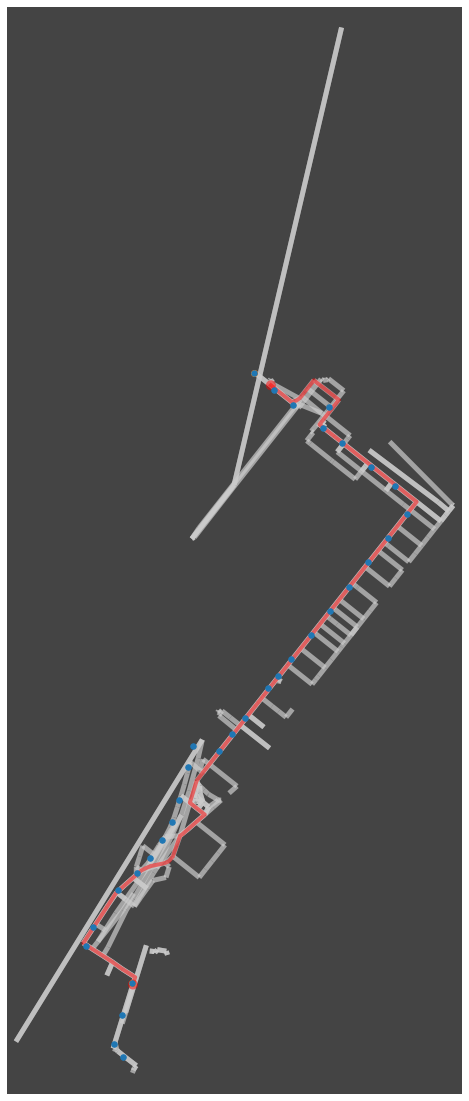

In [110]:
fig, ax = plt.subplots(figsize=(30, 20))
#ox.plot_graph(bk, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#333')
ox.plot_graph(route_subgraph, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#ccc', edge_linewidth=5, edge_alpha=0.7)
#b0_gdf.plot(ax=ax, zorder=10, markersize=10, alpha=0.5)
stops_gdf.plot(ax=ax, zorder=20, markersize=30, alpha=1.0)
ox.plot_graph_route(bk, route, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#00c', edge_linewidth=5, edge_alpha=1.0)
route_start_end_gdf.plot(ax=ax)
ax.set_facecolor('#444')

In [111]:
pd.DataFrame(route).to_csv(f'{EXPORTS_DIR}/route_nodes/{ROUTE.lower()}_route_nodes.csv', index=False)

In [112]:
def create_route_subgraph(node_ids):
    graph = nx.MultiDiGraph()
    for node_id in node_ids:
        node = bk.nodes[node_id]
        graph.add_node(node_id, **node)
    for i in range(0, len(node_ids) - 1):
        graph.add_edge(node_ids[i], node_ids[i + 1])
    graph.graph['crs'] = CRS_PLOT
    return graph
route_graphml = create_route_subgraph(route)
ox.io.save_graphml(route_graphml, f'{EXPORTS_DIR}/graphml/{ROUTE.lower()}.graphml')

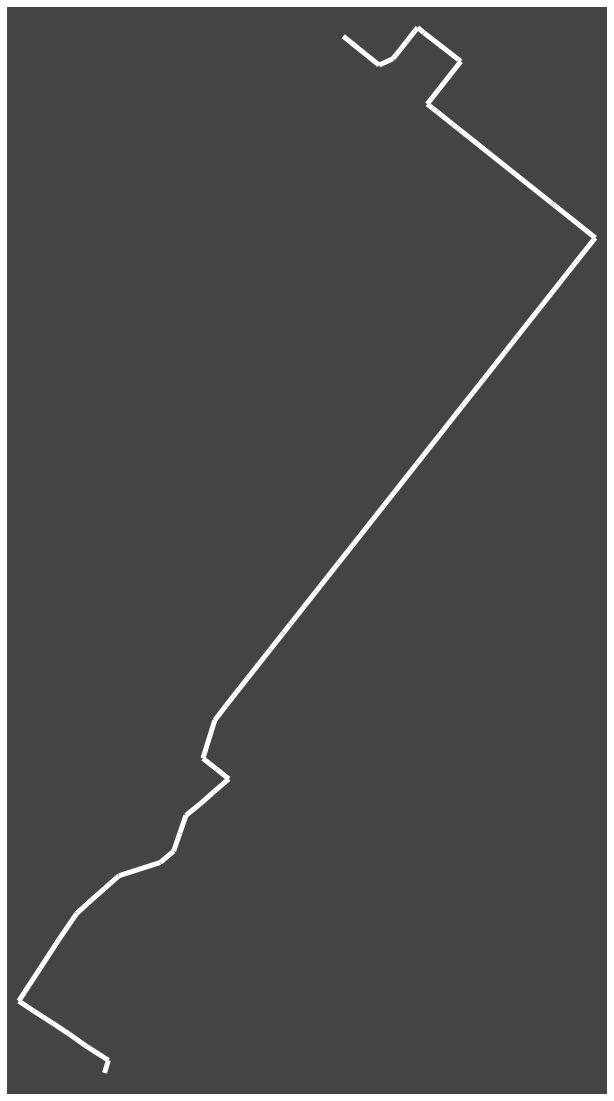

In [113]:
fig, ax = plt.subplots(figsize=(30, 20))
ox.plot_graph(route_graphml, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#fff', edge_linewidth=5)
ax.set_facecolor('#444')